In [18]:
import os

# for data handling
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for data pre-processing
from sklearn.feature_extraction.text import TfidfVectorizer

# for classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# for evaluation purposes
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score, precision_score, recall_score, auc, classification_report, ConfusionMatrixDisplay, make_scorer

# for custom gridsearch
from itertools import product

# for oversampling
from imblearn.over_sampling import SMOTE, RandomOverSampler

# for experiment tracking
import mlflow
import mlflow.sklearn

In [19]:
# Bash code executed in terminal
!mlflow ui

^C


In [ ]:
# init mlflow backend uri
# we store the logging database at `database` dir under the name `mlflow.db`
# mlflow ui --backend-store-uri sqlite:///database/mlflow.db

# load the url: http://127.0.0.1:5000` to view the database

# set tracking uri to the logging database
mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment = mlflow.set_experiment("SMS Spam Detection")

# extract experiment id
experiment_id = experiment.experiment_id
print("Experiment ID:", experiment_id)

Experiment ID: 879140896982592757


In [ ]:
# train, val, test save_paths

data_train_save_path = os.path.join('data','train.csv')
data_val_save_path = os.path.join('data','val.csv')
data_test_save_path = os.path.join('data','test.csv')

train_val_test_save_paths = [data_train_save_path, data_val_save_path, data_test_save_path]

train_val_test_save_paths

['data\\train.csv', 'data\\val.csv', 'data\\test.csv']

In [ ]:
# Function to load data
def load_data(file_path):
    return pd.read_csv(file_path)

# Function to preprocess data (with consistent vectorization)
def preprocess_data(train_df, val_df, test_df):
    # Extract text and labels
    X_train, y_train = train_df['text'], train_df['label']
    X_val, y_val = val_df['text'], val_df['label']
    X_test, y_test = test_df['text'], test_df['label']

    # Initialize TF-IDF Vectorizer (fit only on training data)
    tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    # Transform validation and test data using the same vectorizer
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Convert from sparse matrix to DataFrame
    X_train_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf)
    X_val_tfidf = pd.DataFrame.sparse.from_spmatrix(X_val_tfidf)
    X_test_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf)

    return X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test

# Load datasets
df_train = load_data(data_train_save_path)
df_val = load_data(data_val_save_path)
df_test = load_data(data_test_save_path)

# Preprocess data with consistent TF-IDF vectorization
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df_train, df_val, df_test)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (3788, 6894)
X_val shape: (948, 6894)
X_test shape: (836, 6894)


In [ ]:
def train_model(X_train, X_val, y_train, y_val, classifier, param_grid):
    # extract classifier name
    classifier_name = classifier.__class__.__name__
    run_name = classifier_name + str("_run")

    # set run_tag
    run_tags = {
        "model": classifier_name,
        "developer": "sampadk04",
    }
    
    # init best model
    best_model = classifier
    
    # best precision
    best_precision = 0.0

    # make param_list by considering set products of params
    param_list = list(product(*param_grid.values()))

    for param in param_list:
        # log each run using mlflow
        with mlflow.start_run(run_name=run_name, experiment_id=experiment_id):
            # set tags for the run
            mlflow.set_tags(run_tags)
            
            # extract the parameters
            param_dict = dict(zip(param_grid.keys(), param))
            # log the parameters
            mlflow.log_params(param_dict)
            
            # init model with these params
            model = classifier.set_params(**param_dict)
            # fit the model on train data
            model.fit(X_train, y_train)

            # evaluate the model on val data
            y_val_hat = model.predict(X_val)
            y_val_prob = model.predict_proba(X_val)[:, 1]
            
            # calculate precision
            current_precision = precision_score(y_val, y_val_hat, average='micro')
            # log precision_score
            mlflow.log_metric(key="precision", value=current_precision)

            # calculate the area under the precision-recall curve (AUCPR)
            precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)
            aucpr = auc(recall, precision)
            # log aucpr
            mlflow.log_metric(key="AUCPR", value=aucpr)

            # log the model
            mlflow.sklearn.log_model(model, classifier_name)

            # update model, score based on val precision
            if current_precision > best_precision:
                best_precision = current_precision
                best_model = model
                
                print("\nCurrent Best Precision on Val: %.3f" % best_precision)
    
    # print the best classifier
    print("Overall Best Model:", best_model)
    print("Overall Best Precision on Val: %.3f" % best_precision)

    return best_model

In [ ]:
experiment = mlflow.set_experiment("SMS Spam Detection")

# extract experiment id
experiment_id = experiment.experiment_id
print("Experiment ID:", experiment_id)

Experiment ID: 879140896982592757


In [ ]:
import logging
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress MLflow warnings
logging.getLogger("mlflow").setLevel(logging.ERROR)

# Suppress Convergence Warnings
warnings.simplefilter("ignore", category=ConvergenceWarning)


#logging.getLogger("mlflow").setLevel(logging.ERROR)  # Suppress MLflow logs
logging.getLogger("urllib3").setLevel(logging.ERROR)  # Suppress HTTP logging

## Logistic Regression

2025/03/12 21:39:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Current Best Precision on Val: 0.862
🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/323e2a802870417db8511006f67984d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/094e7a673e0b4979bb8ceb66e7199622
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/8b397967f8934ac4af4335bfce6ba57d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/8ec718b943834b4386d5755e16b75b79
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/ed118cecac0f4524a4ee92e6171ccc4f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/0ed7b41dad344352be0d9d1c97f3a1fa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Current Best Precision on Val: 0.863
🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/42bb66942b4a4d16b88c027495b5f27e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/bf34d431b4c447f69c974cf6bd203372
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/e9acbfdc0cbb42b5a08c8cbc1e7dc846
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Current Best Precision on Val: 0.959
🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3db69d8d6c4e4087bd1ef35a7173a650
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:39:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2bd3140d1a4d480c8b7f9eb941cd576b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:40:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/6c93769fac554556817ec81579cc584b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


c:\Users\Ankita\Desktop\Sem 4\Applied ML\Assignments\myenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025/03/12 21:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Current Best Precision on Val: 0.978
🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/615627173ad34d058b56613af1d82c25
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


c:\Users\Ankita\Desktop\Sem 4\Applied ML\Assignments\myenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025/03/12 21:40:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/9863a7dbeff04f0bac3b9f50b6ef4125
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


c:\Users\Ankita\Desktop\Sem 4\Applied ML\Assignments\myenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025/03/12 21:40:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/7bf4102ba9dc43f3a2943a174be03800
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:40:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/b7db8d02c325461bbe172ab966012320
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:40:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/4c66ecbc30984de1a2fb238ca9e52ca1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:40:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/b21b6ee800384cdba885676bb7248a2e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:40:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/6f4ed2ac835941509a80f761b915bfe9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:40:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3dc988f99bc14d72902376400d6abfae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:40:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/a106e8f5c32b4667801afeeb70771cce
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2e813fa9d7bc4a1d962e20a618bc56f6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/191e59e596c64ccdb36ad79ac421c171
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/840f7b1a733045f7b2c85d42e08b506e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/232920c1a21743bf9f29095a7de20184
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/f97d7cc48c40403e9fa7a2c0bc563921
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/f54a66ccb9de426e8e34787a47f31dae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Current Best Precision on Val: 0.983
🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/5f8a6dc50ddc4bc5b55caef4ac7d7923
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/c9e5f7d0cc6d422db3878b89489a1170
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 21:41:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/e65d2a5ff21f4e41b2c3463060aaa471
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757
Overall Best Model: LogisticRegression(C=10, max_iter=500, solver='liblinear')
Overall Best Precision on Val: 0.983


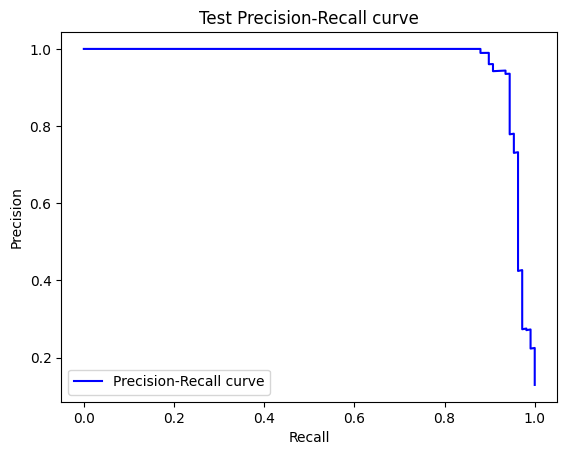

Area under the PRCurve for Test Data: 0.9667777209838346


In [ ]:
classifier = LogisticRegression()

# define the parameter search space for gridsearch

param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10],
              'solver': ['liblinear'],
              'max_iter': [100, 200, 500]}

best_logit = train_model(
                            X_train=X_train,
                            X_val=X_val,
                            y_train=y_train,
                            y_val=y_val,
                            classifier=classifier,
                            param_grid=param_grid
                            )


# Plot PRCurve on the Test Data
y_test_prob = best_logit.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
plt.figure()
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Test Precision-Recall curve")
plt.legend()
plt.show()

# Calculate the Area under the PRCurve
aucpr = auc(recall, precision)
print("Area under the PRCurve for Test Data:", aucpr)

## Random Forest Classifier

2025/03/12 22:21:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Current Best Precision on Val: 0.862
🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/a7af5af34ed94e26ba4082654dd005ea
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:21:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/30efee935994461a94eb00acede856bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Current Best Precision on Val: 0.872
🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/56cfe2ece0ce404db84588e4e28f27a6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/54e49d62dd0b4322b34883ab123f1d67
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/29c53e8090e54ca49ce97927467d5b38
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/ce7ab14bc28546208ee5520aaab9e3ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/a65aee0f896447d687710099a8e2a1da
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/ebf7ea61221f44babfa000025b8f361a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/dbdf8716804b406ea710c8bd4474b601
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/49986c0f2b00431bba703ef185503392
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/11386fc349b64c08853a3ae080114aaa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:22:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/03c3846ec7414237b001b9ffaec1d5a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/96e21f05240245298bb169a88322efab
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2c665f909936441180af8a3c72a5782a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/365a1fd633834fbb87553b9e3ee4c1d3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/6fd48a5ef3484861a7a44809af46497d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/66f03508243f48f19cc7d0d3dc3ec456
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/753909dd5ea349d2abea115a866baab9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Current Best Precision on Val: 0.904
🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d677b91c747640ddbf5fd21069f6cc18
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3a6c713de5f64fc6b433f7f2f8d7b3c5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/795a28a2b77a4e6c9a273ff324600116
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/1752f7c8ce8542e3900634f697c4ad0f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:23:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/8faef89a8b16446a933bf9aaea64ac55
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/9bfc754f2abd4933be84915cfbbe49dd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/fb40bd708c2345b69c6ab5dbc0ae7c3c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/984089c544024006b9db0b28894c5dc4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d93b65aea8104fd1a3d2f7d0b170bd6e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2a390bbbb0924b80a758f9aa2e25dfb3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d8698c05eb6644308a386c814c93f758
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/8c5f43866d4945e88d2d4a1f68dc19bb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/32bc9c0225314692a060cf2cc24ab71b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/7aae538889d2450dad4d34ce4a16f074
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:24:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/4c5de69b977f4856a7ea543c28a67d69
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3d9dd4040b164f09ab1e12ebb557f6c8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/b2985cae9a3241808183ada6628252d8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/26a5f4cf8a3245a38ce3cd21adf40d76
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Current Best Precision on Val: 0.923
🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/f900777feddc46c18ebf9e54b4acd3e9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/5ed9cf34d0574e89b97e302a875d4c31
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Current Best Precision on Val: 0.929
🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/a50aeee1075547ac8607a49600724ec8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/7406065fc9e747d0865733486f2506f9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/0880b8a2d968496a99a6eeaf2a101d8b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/e20ac31d54414e4aabc0730bb3cfff58
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:25:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/62494a4bfd72442f9879f93271d01763
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/671fe4e88075472a8926593e291e23c4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d87fd952ca104ce79362f3c9d7695d2c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/42870db8cea04de5807d98c15aaf12b2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3ee15d698cac4a2aaa55ee8a93c6a9a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/a040543680ca45ce83229eb7a6ce429c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/cae76d35e15c4b268f4b37b97f562f41
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/9cc7d57070f94a9f900c367e7111a851
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/c18beacb23cc4f51b4e3848bddbcbdbe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2ed84da461e8494ca3c39ae34ed9b297
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:26:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/851ce4a7fffb4772998ebb9df08cb0eb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d8d69e03698343a9bd16b954d9fa87f5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/6e8ee485172647d09c677cdca0989983
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d2668edd0f7144e29caf2978a41f0194
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/538732ebf90f4b18b7022cb0b21f4162
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3cb8eeb33411491ca3abbef06c52fca7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/f31fa2de6e184e65ae9c1e0b53bef3ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d4c785b9eddd4d2f9611687cc12318d0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2de6985ddc364512ac796cfdaeb45a7f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/6cf5207bf450492cb1fecb68b3102362
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/77ce5be9d8e149de87b2431c3ac20ba0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/fce7f5ac91d34d2caa68b7817129fae8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3244d9ea277c45a7b60a74dd83d83678
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/30a8aee742ce4b1098c62b0d7c4e50ee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2ee79b97ee1348e4860df7af81acd77a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/9a7e9f28c98247dca48d7e41223898d6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d0f1893a171d4b829d5d995097ecfa4e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/7de9434aab60417886ba277b84fd06fb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/c0c3480584b64220bf963304fa6b8312
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/cbb3de6c10ac48db8d277e9a39a1d788
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/cec59d5e130a44dfa48ea1850841f4f3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/5d3250fc850c46baa8f9a5676567a4b3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/79606f9e580348409eab2c63e71bdf10
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:28:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/f08daaed360643728b583d0456a58ca3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/e1036e5822694590a046d063c36d556e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/54aa5ec779e4447aab5a1905831286aa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2d53b76ce5ca4a978b44759b2e6104f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/c6d3a35910184ba29ebcdec5a9f43bea
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/1172e09aec034edf97ef99c9f98529f2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/eae73ce3882846a7af93fc7eeb28566f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/6d62e760cd2a4c17b06aa2794f06e8f4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/682adb6ee15d4ee79d3c9d098bdcfe41
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/b5d134431d094ba9bc4e3fc1db372dab
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/73512fd6f3e24fafb02edc67602456be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:29:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d1e1d078f0ba4ce7b3139ff0c9478a50
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/5137fb4f9f03418ab291cdace6e9bc14
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d48575d473ce40f2929f2a58d6cd82a2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/92831823c2da447fa5321c641d7f4f3b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/cc670e908b364a5ea4e2d5fef0027405
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/984cc26f316f486eb0f4cc6e278f9300
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/07c988044671465aaf0aed871b428fa6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d2c777e7d24c428588cb55d1739024e8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/0c432df6b66c4f7aa81a704534cca038
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/1946eba72fbb4959b4cad8597a9379c7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Current Best Precision on Val: 0.934
🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/84d01888ef2e4d188e6a6b6edb3b5d55
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/54a6d7aed0f147ac8f7e7612cd680696
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:30:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/8f6e6d766f9844c3ad613abdbd0629f1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/141f0ac065ba445db75a91945bf61abb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/7e1afa27a8fa4ecfa84816918dff12ed
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/174e53c31aac4fbe8b5607b178cce42e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3d3d6bd5b8084f90b36d2c12c2935da9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/dc79b2b7d1134265932ace290b43d060
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/8f518cd3a8d8456f96140933107693f2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/05bd110e3ffa4cc585c8fd77b22e4408
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/04767fa50e574a23b683c8ad1e6f6c43
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/438c8ff11760431ea8d0802ee6720c26
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:31:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/8168f475974747d398345cbc30efafef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d5c3eaecf0ba489eab833403db10f93a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/70b80c977eaf47f689ffe315e4a96a96
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/f546d4d9711c43e997e011d83df51aad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/5400a3849b4048eb99a78491780ff4d2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/aecdd04aeaef4278bed2fc0531e1a986
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/1cf2e51429d24e799ba1fecd7272aa09
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/bc86ff89604b4b53a34df44579b12ab4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/a6c81e49b38b4861b9e89babc51a07c9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/dfa98a411aa143758f2bc37ee6f1158d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/e400764b84aa4ae9b7d081ef4d235f6c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:32:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/a1d7f5dcd4cb49fb93f428b0a58cf572
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/4ce120820caa4a7cb3109fe4ba6840f2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/e54d837ad57a4f61a7d5f538e83ce5aa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/b171a8d4b7364905a96313596a0c859b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/05de8a81961f4ddfba999093832ab9cb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/52c72464e59e4aca99f8ae6bf42b106a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/7f41a202ac5040489fbace0e205f2024
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/34baad39904a492dbe0427f6bf1096f1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/4023c8e602fd45e69419b80b4e3702b5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2eebc16422b0474099ca4918e3870907
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/bc54f7ce79d94bc88e2404150a535a75
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/bb65154d83264e02a0b1721ade6a71ab
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:33:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/983e2590cc674df0ac8f32c03df0a5d3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/8e7fc49049364eb1912e9477514ee99f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/ca4926ffd0974c4180170055676b53b0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/4e0044a3a0944dfe8465562c7f7913bf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/eba093c1619c46f4b6a6aea42ff5f1cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/e958b66cf19b4981a20c2557de25a803
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/4540e64be67d410283ab92ba01718d97
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/260866aeea644254b3e718c098524828
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/a5898e49a4e344639d9c03d0d7d53e6c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/e4e58d449fdd494284c949958373ea6e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:34:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/9ab44cae6c944b2196622d82963536c1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/9f6599cbc1334a1bad13fbaf2a0f12f3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/6a516ec9ce9448e8a0d8b128a3f7791f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/4ed5769096ab46ca871622cfbfe90d28
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3ff196b92a174cb2a3c51f7c14123906
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/7b8ad9a6cdc6441aafdf301902627c04
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/b86d3d15afb7403db6f67efee1438a05
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/d678b758b95c49e6962af5a35e00c357
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/cd17a20c55b440beab4c40cbce0a306b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/13c77fa55adf412088e6dead78066de6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:35:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/cd5d599adc6f4b08ab57c82ccdb415b5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/2f78082fe4be45a48c2fc6f464a5de4b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/5010b963d4e1458e9dd28437d0d7b533
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/6643d71f9cf94f328bf934a6ca987de3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/f700e1bad0914954bb9ed009779f3c26
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/738c0462156e422798d431450db79e7f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/677b8bbd55164b4f976a3a04ce384aca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/9fde874d5eaa43b6b7d9d36447efc436
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/55b0c4c081814bd9842ffb2374524c5a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/11a28674f72f4c648092df5faf07f1ca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/12 22:36:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/bdf9cbed757b4668b12d3c671b4ebd8f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757
Overall Best Model: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=200)
Overall Best Precision on Val: 0.934


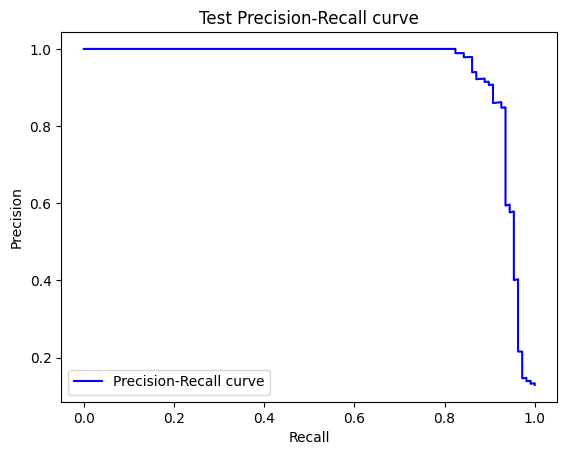

Area under the PRCurve for Test Data: 0.9474149876595132


In [ ]:
classifier = RandomForestClassifier()

# define the parameter search space for gridsearch

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

best_rfc = train_model(
                            X_train=X_train,
                            X_val=X_val,
                            y_train=y_train,
                            y_val=y_val,
                            classifier=classifier,
                            param_grid=param_grid
                            )

# Plot PRCurve on the Test Data
y_test_prob = best_rfc.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
plt.figure()
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Test Precision-Recall curve")
plt.legend()
plt.show()

# Calculate the Area under the PRCurve
aucpr = auc(recall, precision)
print("Area under the PRCurve for Test Data:", aucpr)

## Naive Baes Classifier

2025/03/13 00:36:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Current Best Precision on Val: 0.983
🏃 View run MultinomialNB_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/5fca516a091b4d0091981a326942f6ff
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/13 00:37:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MultinomialNB_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/30083445c2e046c390d67632c0f1f254
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/13 00:37:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MultinomialNB_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/74edf64ff03f4f608cfe8f2b8bed8d8a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/13 00:37:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MultinomialNB_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/3508683f29d1467a943038f9ce359478
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757


2025/03/13 00:37:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MultinomialNB_run at: http://127.0.0.1:5000/#/experiments/879140896982592757/runs/907a70b72b55455097e03c98395f1495
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/879140896982592757
Overall Best Model: MultinomialNB(alpha=5.0)
Overall Best Precision on Val: 0.983


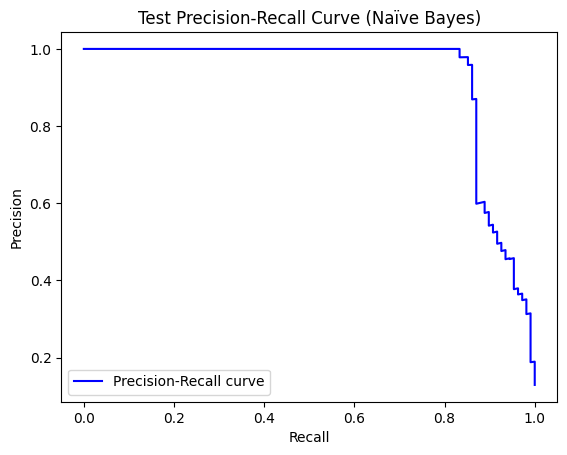

Area under the PRCurve for Test Data (Naïve Bayes): 0.9269852566596064


In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Define Naïve Bayes classifier
classifier = MultinomialNB()

# Define parameter grid for GridSearch
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]  # Smoothing parameter
}

# Train model using GridSearch
best_nb = train_model(
                        X_train=X_train,
                        X_val=X_val,
                        y_train=y_train,
                        y_val=y_val,
                        classifier=classifier,
                        param_grid=param_grid
                    )

# Plot Precision-Recall Curve on Test Data
y_test_prob = best_nb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
plt.figure()
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Test Precision-Recall Curve (Naïve Bayes)")
plt.legend()
plt.show()

# Calculate AUC-PR
aucpr = auc(recall, precision)
print("Area under the PRCurve for Test Data (Naïve Bayes):", aucpr)


Best Model According to AUCPR score is Logistic Regression.